In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import glob

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, auc
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [ ]:
path = 'data/processed_data/coded_data/*.csv'

frames = []

# Process each file in chunks
for fname in glob.glob(path):
    chunks = pd.read_csv(fname, chunksize=500000)  
    for chunk in chunks:
        frames.append(chunk)

all_data = pd.concat(frames)

print("Data successfully loaded in chunks.")



/var/folders/_q/dhbx23v92q5c0mb27_3jyp000000gn/T/ipykernel_2917/3336156774.py:8: DtypeWarning: Columns (34,36,38,42,44,46,48,61) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in chunks:
/var/folders/_q/dhbx23v92q5c0mb27_3jyp000000gn/T/ipykernel_2917/3336156774.py:8: DtypeWarning: Columns (32,34,36,38,42,44,46,48,61) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in chunks:
/var/folders/_q/dhbx23v92q5c0mb27_3jyp000000gn/T/ipykernel_2917/3336156774.py:8: DtypeWarning: Columns (32,34,36,38,44,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in chunks:
/var/folders/_q/dhbx23v92q5c0mb27_3jyp000000gn/T/ipykernel_2917/3336156774.py:8: DtypeWarning: Columns (34,36,38,42,44,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in chunks:
/var/folders/_q/dhbx23v92q5c0mb27_3jyp000000gn/T/ipykernel_2917/3336156774.py:8: DtypeWarning: Colu

Data successfully loaded in chunks.


In [3]:
all_data.columns

Index(['as_of_year', 'respondent_id', 'agency_name', 'agency_abbr',
       'agency_code', 'loan_type_name', 'loan_type', 'property_type_name',
       'property_type', 'loan_purpose_name', 'loan_purpose',
       'owner_occupancy_name', 'owner_occupancy', 'loan_amount_000s',
       'preapproval_name', 'preapproval', 'action_taken_name', 'action_taken',
       'msamd_name', 'msamd', 'state_name', 'state_abbr', 'state_code',
       'county_name', 'county_code', 'census_tract_number',
       'applicant_ethnicity_name', 'applicant_ethnicity',
       'co_applicant_ethnicity_name', 'co_applicant_ethnicity',
       'applicant_race_name_1', 'applicant_race_1', 'applicant_race_name_2',
       'applicant_race_2', 'applicant_race_name_3', 'applicant_race_3',
       'applicant_race_name_4', 'applicant_race_4', 'applicant_race_name_5',
       'applicant_race_5', 'co_applicant_race_name_1', 'co_applicant_race_1',
       'co_applicant_race_name_2', 'co_applicant_race_2',
       'co_applicant_race_name_

In [7]:
# Column Filtering

X_unfair = filtered_data[['as_of_year', 'loan_type',
       'owner_occupancy', 'loan_amount_000s',
       'preapproval', 'applicant_income_000s', 'rate_spread', 'hud_median_family_income',
       'tract_to_msamd_income', 'number_of_owner_occupied_units',
       'number_of_1_to_4_family_units']].fillna(0)

y = filtered_data['loan_approval']

In [8]:
print(X_unfair.isnull().any())

as_of_year                        False
loan_type                         False
owner_occupancy                   False
loan_amount_000s                  False
preapproval                       False
applicant_income_000s             False
rate_spread                       False
hud_median_family_income          False
tract_to_msamd_income             False
number_of_owner_occupied_units    False
number_of_1_to_4_family_units     False
dtype: bool


Classification Report:
              precision    recall  f1-score   support

         0.0       0.30      0.56      0.39     69755
         1.0       0.89      0.73      0.80    346765

    accuracy                           0.70    416520
   macro avg       0.60      0.65      0.60    416520
weighted avg       0.79      0.70      0.73    416520

Precision-Recall AUC: 0.919515132590468


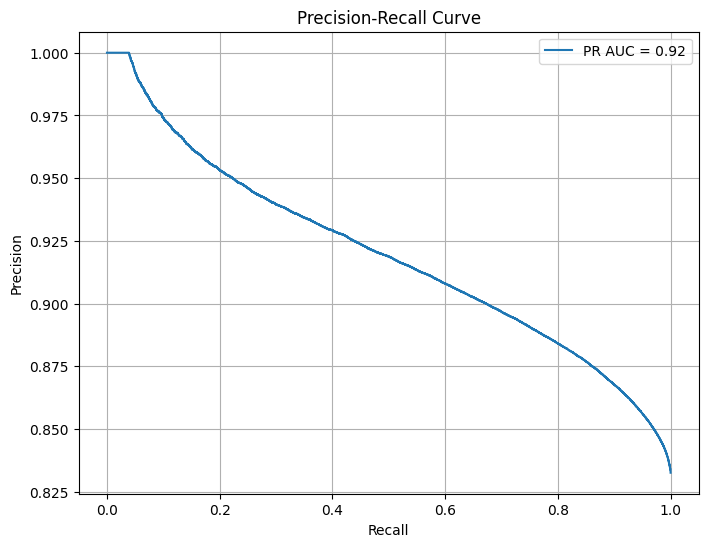

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_unfair, y, test_size=0.3, random_state=42, stratify=y)

# Train a simple Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    max_depth=15, # Maximum depth of each tree (adjustable)
    min_samples_split=5, 
    min_samples_leaf=2,
    class_weight={0: 5, 1: 1}, # Higher weight for minority class
    random_state=42    # For reproducibility
)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]  # Get probabilities for Precision-Recall

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc}")

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

**Fairer Model**

In [10]:
# Column Filtering

X_fair = filtered_data[['as_of_year', 'loan_type',
       'owner_occupancy', 'loan_amount_000s',
       'preapproval', 'applicant_income_000s', 'rate_spread', 'hud_median_family_income',
       'tract_to_msamd_income', 'number_of_owner_occupied_units',
       'number_of_1_to_4_family_units','applicant_ethnicity_name', 'applicant_ethnicity',
       'co_applicant_ethnicity_name', 'co_applicant_ethnicity',
       'applicant_race_name_1', 'applicant_race_1', 'applicant_race_name_2',
       'applicant_race_2', 'applicant_race_name_3', 'applicant_race_3',
       'applicant_race_name_4', 'applicant_race_4', 'applicant_race_name_5',
       'applicant_race_5', 'co_applicant_race_name_1', 'co_applicant_race_1',
       'co_applicant_race_name_2', 'co_applicant_race_2',
       'co_applicant_race_name_3', 'co_applicant_race_3',
       'co_applicant_race_name_4', 'co_applicant_race_4',
       'co_applicant_race_name_5', 'co_applicant_race_5', 'applicant_sex_name',
       'applicant_sex', 'co_applicant_sex_name', 'co_applicant_sex', 'minority_population']].fillna(0)

y = filtered_data['loan_approval']

In [13]:
print(X_fair.isnull().any())

as_of_year                        False
loan_type                         False
owner_occupancy                   False
loan_amount_000s                  False
preapproval                       False
applicant_income_000s             False
rate_spread                       False
hud_median_family_income          False
tract_to_msamd_income             False
number_of_owner_occupied_units    False
number_of_1_to_4_family_units     False
applicant_ethnicity_name          False
applicant_ethnicity               False
co_applicant_ethnicity_name       False
co_applicant_ethnicity            False
applicant_race_name_1             False
applicant_race_1                  False
applicant_race_name_2             False
applicant_race_2                  False
applicant_race_name_3             False
applicant_race_3                  False
applicant_race_name_4             False
applicant_race_4                  False
applicant_race_name_5             False
applicant_race_5                  False


In [14]:
print(X_fair.dtypes)

as_of_year                          int64
loan_type                           int64
owner_occupancy                     int64
loan_amount_000s                    int64
preapproval                         int64
applicant_income_000s             float64
rate_spread                       float64
hud_median_family_income          float64
tract_to_msamd_income             float64
number_of_owner_occupied_units    float64
number_of_1_to_4_family_units     float64
applicant_ethnicity_name           object
applicant_ethnicity                 int64
co_applicant_ethnicity_name        object
co_applicant_ethnicity              int64
applicant_race_name_1              object
applicant_race_1                    int64
applicant_race_name_2              object
applicant_race_2                  float64
applicant_race_name_3              object
applicant_race_3                  float64
applicant_race_name_4              object
applicant_race_4                  float64
applicant_race_name_5             

In [15]:
exclude_columns = [
    'applicant_ethnicity_name', 'co_applicant_ethnicity_name',
    'applicant_race_name_1', 'applicant_race_name_2', 'applicant_race_name_3',
    'applicant_race_name_4', 'applicant_race_name_5', 
    'co_applicant_race_name_1', 'co_applicant_race_name_2',
    'co_applicant_race_name_3', 'co_applicant_race_name_4',
    'co_applicant_race_name_5', 'applicant_sex_name', 'co_applicant_sex_name'
]

# Drop the columns from X_fair
X_fair = X_fair.drop(columns=exclude_columns)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.30      0.58      0.40     69755
         1.0       0.90      0.73      0.80    346765

    accuracy                           0.70    416520
   macro avg       0.60      0.65      0.60    416520
weighted avg       0.80      0.70      0.73    416520

Precision-Recall AUC: 0.9210225030508931


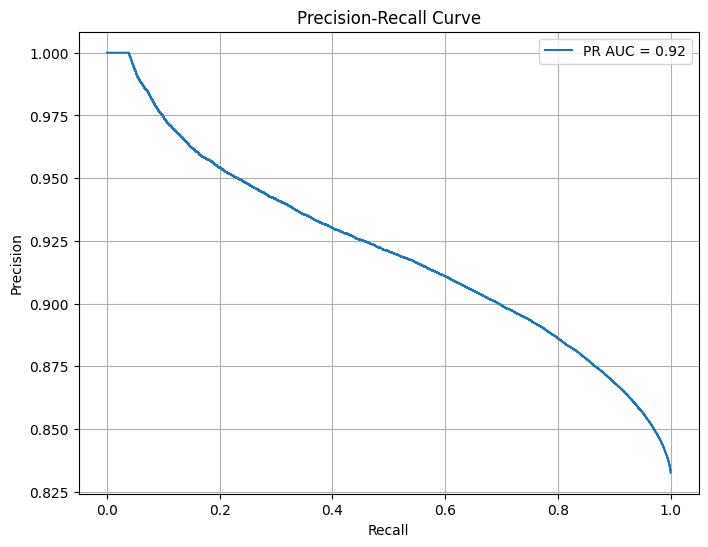

In [16]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_fair, y, test_size=0.3, random_state=42, stratify=y)

# Train a simple Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    max_depth=15, # Maximum depth of each tree (adjustable)
    min_samples_split=5, 
    min_samples_leaf=2,
    class_weight={0: 5, 1: 1}, # Higher weight for minority class
    random_state=42    # For reproducibility
)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]  # Get probabilities for Precision-Recall

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc}")

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()